# Creating Sequence to Sequence Models

----------------------------------

Here we show how to implement sequence to sequence models. Specifically, we will build an English to German translation model.


We start by loading the necessary libraries

In [1]:
import os
import re
import sys
import string
import requests
import io
import numpy as np
import collections
import random
import pickle
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from zipfile import ZipFile
from collections import Counter
from tensorflow.python.framework import ops
ops.reset_default_graph()

TensorFlow has a separate `models` folder that holds some great models that we can use.  One of these is a seq2seq model that we will use to train on our translation data. The models are located here:

https://github.com/tensorflow/models

And specifically, the seq2seq model and utilities are located here:

https://github.com/tensorflow/models/tree/master/tutorials/rnn/translate
    
If you want to download them separately, you may do that.  The goal here is to access the `data_utils.py` and the `seq2seq_model.py` scripts in the above folder.  We will import them.

The following block of code will import the whole `models` repository into the temp folder.

In [2]:
local_repository = 'temp'
if not os.path.exists(local_repository):
    from git import Repo
    tf_model_repository = 'https://github.com/tensorflow/models'
    Repo.clone_from(tf_model_repository, local_repository)

Now that we have downloaded the model files, we import the necessary funtions.

In [3]:
sys.path.insert(0, 'temp/tutorials/rnn/translate/')
import seq2seq_model as seq2seq_model
import data_utils as data_utils

Now we start a computational graph session.

In [4]:
sess = tf.Session()

We setup the model parameters for our seq2seq model.

In [6]:
# Model Parameters
learning_rate = 0.1
lr_decay_rate = 0.99
lr_decay_every = 100
max_gradient = 5.0
batch_size = 50
num_layers = 3
rnn_size = 500
layer_size = 512
generations = 10000
vocab_size = 10000
save_every = 1000
eval_every = 500
output_every = 50
punct = string.punctuation

We want to download the data, save the data, save the model, and create test english sentences for the model to be evaluated on.

In [7]:
# Data Parameters
data_dir = 'temp'
data_file = 'eng_ger.txt'
model_path = 'seq2seq_model'
full_model_dir = os.path.join(data_dir, model_path)

# Test Translation from English (lowercase, no punct)
test_english = ['hello where is my computer',
                'the quick brown fox jumped over the lazy dog',
                'is it going to rain tomorrow']

Now we create the model directory if it doesn't exist.

After, we load the english-german sentence translation data.

In [8]:
# Make Model Directory
if not os.path.exists(full_model_dir):
    os.makedirs(full_model_dir)

print('Loading English-German Data')
# Check for data, if it doesn't exist, download it and save it
if not os.path.isfile(os.path.join(data_dir, data_file)):
    print('Data not found, downloading Eng-Ger sentences from www.manythings.org')
    sentence_url = 'http://www.manythings.org/anki/deu-eng.zip'
    r = requests.get(sentence_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('deu.txt')
    # Format Data
    eng_ger_data = file.decode()
    eng_ger_data = eng_ger_data.encode('ascii',errors='ignore')
    eng_ger_data = eng_ger_data.decode().split('\n')
    # Write to file
    with open(os.path.join(data_dir, data_file), 'w') as out_conn:
        for sentence in eng_ger_data:
            out_conn.write(sentence + '\n')
else:
    eng_ger_data = []
    with open(os.path.join(data_dir, data_file), 'r') as in_conn:
        for row in in_conn:
            eng_ger_data.append(row[:-1])
print('Done!')

Loading English-German Data


Remove punctuation and separate the english-german sentences.

In [9]:
# Remove punctuation
eng_ger_data = [''.join(char for char in sent if char not in punct) for sent in eng_ger_data]

# Split each sentence by tabs    
eng_ger_data = [x.split('\t') for x in eng_ger_data if len(x)>=1]
[english_sentence, german_sentence] = [list(x) for x in zip(*eng_ger_data)]
english_sentence = [x.lower().split() for x in english_sentence]
german_sentence = [x.lower().split() for x in german_sentence]

Now we process the english, german, and test sentences.  We need to create a lookup that translates words to an index number.  Note that we purposely exclude the index 0, because that will stand for an unknown word (rare or new words).

In [10]:
print('Processing the vocabularies.')
# Process the English Vocabulary
all_english_words = [word for sentence in english_sentence for word in sentence]
all_english_counts = Counter(all_english_words)
eng_word_keys = [x[0] for x in all_english_counts.most_common(vocab_size-1)] #-1 because 0=unknown is also in there
eng_vocab2ix = dict(zip(eng_word_keys, range(1,vocab_size)))
eng_ix2vocab = {val:key for key, val in eng_vocab2ix.items()}
english_processed = []
for sent in english_sentence:
    temp_sentence = []
    for word in sent:
        try:
            temp_sentence.append(eng_vocab2ix[word])
        except:
            temp_sentence.append(0)
    english_processed.append(temp_sentence)


# Process the German Vocabulary
all_german_words = [word for sentence in german_sentence for word in sentence]
all_german_counts = Counter(all_german_words)
ger_word_keys = [x[0] for x in all_german_counts.most_common(vocab_size-1)]
ger_vocab2ix = dict(zip(ger_word_keys, range(1,vocab_size)))
ger_ix2vocab = {val:key for key, val in ger_vocab2ix.items()}
german_processed = []
for sent in german_sentence:
    temp_sentence = []
    for word in sent:
        try:
            temp_sentence.append(ger_vocab2ix[word])
        except:
            temp_sentence.append(0)
    german_processed.append(temp_sentence)


# Process the test english sentences, use '0' if word not in our vocab
test_data = []
for sentence in test_english:
    temp_sentence = []
    for word in sentence.split(' '):
        try:
            temp_sentence.append(eng_vocab2ix[word])
        except:
            # Use '0' if the word isn't in our vocabulary
            temp_sentence.append(0)
    test_data.append(temp_sentence)
print('Done!')

Processing the vocabularies.
Done!


Because the input/output sentences can be of very different lengths (1 word vs a whole sentence), we will bucket the sentences by input/output lenghts.  For each bucket, we will train a different seq2seq model.

In [11]:
# Define Buckets for sequence lengths
# We will split data into the corresponding buckets:
# (x1, y1), (x2, y2), ...
# Where all entries in bucket 1: len(x)<x1 and len(y)<y1 and so on.
x_maxs = [5, 7, 11, 50]
y_maxs = [10, 12, 17, 60]
buckets = [x for x in zip(x_maxs, y_maxs)]
bucketed_data = [[] for _ in range(len(x_maxs))]
for eng, ger in zip(english_processed, german_processed):
    for ix, (x_max, y_max) in enumerate(zip(x_maxs, y_maxs)):
        if (len(eng) <= x_max) and (len(ger) <= y_max):
            bucketed_data[ix].append([eng, ger])
            break

# Print summaries of buckets
train_bucket_sizes = [len(bucketed_data[b]) for b in range(len(buckets))]
train_total_size = float(sum(train_bucket_sizes))
for ix, bucket in enumerate(bucketed_data):
    print('Data pts in bucket {}: {}'.format(ix, len(bucket)))

Data pts in bucket 0: 57222
Data pts in bucket 1: 47613
Data pts in bucket 2: 36158
Data pts in bucket 3: 6795


Now we declare our seq2seq model function.

In [12]:
# Create sequence to sequence model
def translation_model(sess, input_vocab_size, output_vocab_size,
                      buckets, rnn_size, num_layers, max_gradient,
                      learning_rate, lr_decay_rate, forward_only):
    model = seq2seq_model.Seq2SeqModel(
          input_vocab_size,
          output_vocab_size,
          buckets,
          rnn_size,
          num_layers,
          max_gradient,
          batch_size,
          learning_rate,
          lr_decay_rate,
          forward_only=forward_only,
          dtype=tf.float32)
    return(model)

Now we create our train/test models. We want these models to use the exact same variables, so we have to tell TensorFlow to reuse the variables when we create the test-model.

In [13]:
print('Creating Translation Model')
input_vocab_size = vocab_size
output_vocab_size = vocab_size

translate_model = translation_model(sess=sess,
                                    input_vocab_size=vocab_size,
                                    output_vocab_size=vocab_size,
                                    buckets=buckets,
                                    rnn_size=rnn_size,
                                    num_layers=num_layers,
                                    max_gradient=max_gradient,
                                    learning_rate=learning_rate,
                                    lr_decay_rate=lr_decay_rate,
                                    forward_only=False)

# Tell TensorFlow to reuse the variables for the test model
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    #Reuse the variables for the test model
    test_model = translation_model(sess=sess,
                                    input_vocab_size=vocab_size,
                                    output_vocab_size=vocab_size,
                                    buckets=buckets,
                                    rnn_size=rnn_size,
                                    num_layers=num_layers,
                                    max_gradient=max_gradient,
                                    learning_rate=learning_rate,
                                    lr_decay_rate=lr_decay_rate,
                                    forward_only=True)
    test_model.batch_size = 1

Creating Translation Model


Now we can initialize the model variables.

In [14]:
# Initialize all model variables
init = tf.global_variables_initializer()
sess.run(init)

We now start the training.  For each iteration, we pick a random bicket, and get a batch of sentences from that bucket.  There are then trained on.

In [15]:
# Start training
train_loss = []
for i in range(generations):
    rand_bucket_ix = np.random.choice(len(bucketed_data))
    
    model_outputs = translate_model.get_batch(bucketed_data, rand_bucket_ix)
    encoder_inputs, decoder_inputs, target_weights = model_outputs
    
    # Get the (gradient norm, loss, and outputs)
    _, step_loss, _ = translate_model.step(sess, encoder_inputs, decoder_inputs,
                                           target_weights, rand_bucket_ix, False)
    
    # Output status
    if (i+1) % output_every == 0:
        train_loss.append(step_loss)
        print('Gen #{} out of {}. Loss: {:.4}'.format(i+1, generations, step_loss))
    
    # Check if we should decay the learning rate
    if (i+1) % lr_decay_every == 0:
        sess.run(translate_model.learning_rate_decay_op)
        
    # Save model
    if (i+1) % save_every == 0:
        print('Saving model to {}.'.format(full_model_dir))
        model_save_path = os.path.join(full_model_dir, "eng_ger_translation.ckpt")
        translate_model.saver.save(sess, model_save_path, global_step=i)
        
    # Eval on test set
    if (i+1) % eval_every == 0:
        for ix, sentence in enumerate(test_data):
            # Find which bucket sentence goes in
            bucket_id = next(index for index, val in enumerate(x_maxs) if val>=len(sentence))
            # Get RNN model outputs
            encoder_inputs, decoder_inputs, target_weights = test_model.get_batch(
                {bucket_id: [(sentence, [])]}, bucket_id)
            # Get logits
            _, test_loss, output_logits = test_model.step(sess, encoder_inputs, decoder_inputs,
                                                           target_weights, bucket_id, True)
            ix_output = [int(np.argmax(logit, axis=1)) for logit in output_logits]
            # If there is a 0 symbol in outputs end the output there.
            ix_output = ix_output[0:[ix for ix, x in enumerate(ix_output+[0]) if x==0][0]]
            # Get german words from indices
            test_german = [ger_ix2vocab[x] for x in ix_output]
            print('English: {}'.format(test_english[ix]))
            print('German: {}'.format(test_german))

Gen #50 out of 10000. Loss: 8.335
Gen #100 out of 10000. Loss: 5.929
Gen #150 out of 10000. Loss: 5.74
Gen #200 out of 10000. Loss: 5.884
Gen #250 out of 10000. Loss: 5.682
Gen #300 out of 10000. Loss: 5.622
Gen #350 out of 10000. Loss: 5.546
Gen #400 out of 10000. Loss: 5.555
Gen #450 out of 10000. Loss: 5.608
Gen #500 out of 10000. Loss: 5.359
English: hello where is my computer
German: ['ich', 'ist', 'ist', 'ist', 'nicht', 'nicht', 'nicht', 'zu', 'zu', 'zu']
English: the quick brown fox jumped over the lazy dog
German: ['wir', 'ist', 'ist', 'ist', 'ist', 'nicht', 'zu', 'zu', 'zu', 'zu', 'zu', 'zu', 'zu', 'zu', 'zu', 'zu', 'zu']
English: is it going to rain tomorrow
German: ['wir', 'ist', 'ist', 'ist', 'nicht', 'nicht', 'zu', 'zu', 'zu', 'zu', 'zu', 'zu']
Gen #550 out of 10000. Loss: 5.308
Gen #600 out of 10000. Loss: 5.269
Gen #650 out of 10000. Loss: 5.234
Gen #700 out of 10000. Loss: 5.18
Gen #750 out of 10000. Loss: 5.351
Gen #800 out of 10000. Loss: 5.521
Gen #850 out of 10000. 

Here is matplotib code to plot the training loss over the 10000 iterations.

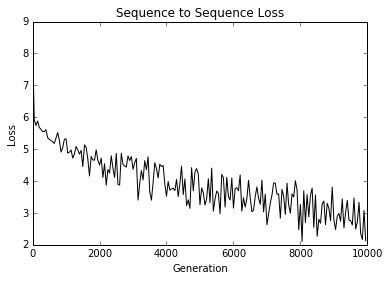

In [16]:
# Plot train loss
loss_generations = [i for i in range(generations) if i%output_every==0]
plt.plot(loss_generations, train_loss, 'k-')
plt.title('Sequence to Sequence Loss')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()